# Install and Set Up Kaggle and API Key

Follow these steps to install and configure the Kaggle API on your system:

1. **Create a Kaggle Account**
   - Visit [Kaggle](https://www.kaggle.com) and sign up for an account.

2. **Obtain Kaggle API Key**
   - Go to your Kaggle account settings.
   - Find the "API" section and click on "Create New API Token".
   - This will download a `kaggle.json` file containing your API key.

3. **Install Kaggle Package**
   - Use Conda to install the Kaggle package by running:
     ```bash
     conda install kaggle
     ```

4. **Configure API Key**
   - Copy the `kaggle.json` file to your user directory under the `.kaggle` folder. On most systems, you can use the following command:
     ```bash
     mkdir -p ~/.kaggle
     cp path_to_downloaded_kaggle.json ~/.kaggle/kaggle.json
     chmod 600 ~/.kaggle/kaggle.json
     ```
   - Ensure the `.kaggle` directory and the `kaggle.json` file have the proper permissions by setting:
     ```bash
     chmod 600 ~/.kaggle/kaggle.json
     ```


In [77]:
import pandas as pd
import kaggle
# Pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import numpy as np


# Scoring 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#potting
import matplotlib.pyplot as plt



In [78]:
# Get the data using an API call
kaggle.api.dataset_download_files('rodsaldanha/arketing-campaign', path='resources', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign


In [79]:
# Import the data
data = pd.read_csv("./resources/marketing_campaign.csv",delimiter=';')


# EDA (Exploratory Data Analysis)
We will revisit this. For now We want the rough draft of the model
#
During EDA

Visualize the data using plots and graphs to understand distributions and relationships between variables.
Calculate summary statistics to get a sense of the central tendencies and variability.
Identify any correlations between variables that might influence model choices.
Detect and treat missing values or outliers that could skew the results of your analysis.
Explore the data's structure to inform feature selection and engineering, which are key to building effective machine learning models.

# read any and all documentation you can find on your dataset to understand it better


In [80]:
display (data.head())
# what does our data look like? At this point also use any documentation on the data set to find out what each value means and how it might be used is solving the business problem
display (data.shape)
display (data.dtypes)
print (f'Columns with NA valuses \n {data.isna().sum()[lambda x: x > 0]}')
# Make desision about null values. Can we fill them of should we drop rows with null values?
non_numeric= (data.dtypes[(data.dtypes != 'int64') & (data.dtypes != 'float64')]).index.tolist()
# display (data.dtypes)
print (f'Columns that are not numeric :\n {non_numeric}')
# Explore non numberic type to see how we can use them in the model

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


(2240, 29)

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Columns with NA valuses 
 Income    24
dtype: int64
Columns that are not numeric :
 ['Education', 'Marital_Status', 'Dt_Customer']


In [81]:

# Define the generational labels and ranges
def assign_generation(year):
    if year <= 1927:
        return 'Greatest Generation'
    elif 1928 <= year <= 1945:
        return 'Silent Generation'
    elif 1946 <= year <= 1964:
        return 'Baby Boomers'
    elif 1965 <= year <= 1980:
        return 'Generation X'
    elif 1981 <= year <= 1996:
        return 'Millennials (Gen Y)'
    elif 1997 <= year <= 2012:
        return 'Generation Z (Gen Z)'
    else:
        return 'Generation Alpha'

# Apply the function to create a new column 'Generation'
data['Generation'] = data['Year_Birth'].apply(assign_generation)

# Print out a sample to ensure correctness
print(data[['Year_Birth', 'Generation']].head())

   Year_Birth           Generation
0        1957         Baby Boomers
1        1954         Baby Boomers
2        1965         Generation X
3        1984  Millennials (Gen Y)
4        1981  Millennials (Gen Y)


In [82]:
start_date = data['Dt_Customer'].min()
end_date = data['Dt_Customer'].max()

# Display the start and end dates
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Start Date: 2012-07-30
End Date: 2014-06-29


In [83]:
from datetime import datetime as dt
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
# set sample date to the date of the dataset creation
sample_date = dt(2014, 6, 29)
data['Months_Customer'] = ((sample_date.year - data['Dt_Customer'].dt.year) * 12 +
                                 (sample_date.month - data['Dt_Customer'].dt.month))
data = data.drop('Dt_Customer', axis=1)
        

In [84]:
# just to get started we will drop NA and columns that are not numberic. this will let us get a rough model
# we come back to this and preprocess based on the draft results if needed

# data_drop_columns = data.drop(columns=non_numeric, axis=1)
data_drop_columns = data.drop(columns=["ID","Year_Birth"], axis=1)
data_drop_na = data_drop_columns.dropna()
df = data_drop_na.copy()
df.head()



,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Generation,Months_Customer
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,3,11,1,Baby Boomers,21
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,3,11,0,Baby Boomers,3
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,3,11,0,Generation X,10
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,3,11,0,Millennials (Gen Y),4
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,3,11,0,Millennials (Gen Y),5


In [85]:
# look for balance of our data
df["Response"].value_counts()

Response
0    1883
1     333
Name: count, dtype: int64

In [86]:
# Split data into Train and Test **80/20 split**
# add verbage as to why we picked response

# X = df.drop('Response', axis=1)
# y = df["Response"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# # This will split 'X' and 'y' such that 80% is used for training and 20% is used for testing.


In [87]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Months_Customer
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271,11.193592
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417,6.650445
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,6.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,11.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,17.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,23.000000


In [88]:
df["Education"].value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [89]:
pd.set_option('display.max_rows', 500)


In [90]:
print(data[['Year_Birth', 'Generation']].head(10))
data["Generation"].value_counts()

   Year_Birth           Generation
0        1957         Baby Boomers
1        1954         Baby Boomers
2        1965         Generation X
3        1984  Millennials (Gen Y)
4        1981  Millennials (Gen Y)
5        1967         Generation X
6        1971         Generation X
7        1985  Millennials (Gen Y)
8        1974         Generation X
9        1950         Baby Boomers


Generation
Generation X           1069
Baby Boomers            759
Millennials (Gen Y)     385
Silent Generation        24
Greatest Generation       3
Name: count, dtype: int64

In [91]:
# Create an encoder for the 
Age_ord_enc = OrdinalEncoder(categories = [['Baby Boomers','Generation X','Millennials (Gen Y)',"Silent Generation","Greatest Generation"]])

# Train the encoder
Age_ord_enc.fit(df['Generation'].values.reshape(-1,1))


OrdinalEncoder(categories=[['Baby Boomers', 'Generation X',
                            'Millennials (Gen Y)', 'Silent Generation',
                            'Greatest Generation']])

In [92]:
# Create an encoder for the 
Mar_ord_enc = OrdinalEncoder(categories = [['Married','Together','Single','Divorced','Widow',"YOLO","Absurd","Alone"]])

# Train the encoder
Mar_ord_enc.fit(df['Marital_Status'].values.reshape(-1,1))

OrdinalEncoder(categories=[['Married', 'Together', 'Single', 'Divorced',
                            'Widow', 'YOLO', 'Absurd', 'Alone']])

In [93]:
display (df['Education'].value_counts())

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [94]:
# Create an encoder for the backpack_color column
edu_ord_enc = OrdinalEncoder(categories = [['Basic','2n Cycle','Graduation','Master','PhD']], encoded_missing_value=-1, handle_unknown='use_encoded_value', unknown_value=-1)

# Train the encoder
edu_ord_enc.fit(df['Education'].values.reshape(-1,1))


OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master',
                            'PhD']],
               encoded_missing_value=-1, handle_unknown='use_encoded_value',
               unknown_value=-1)

In [95]:
def X_preprocess(X_data):
    # Ensure the data is in the correct format
    X_data = X_data.copy()
    
    # Transform each column into numpy arrays
    marital_status_encoded = Mar_ord_enc.transform(X_data['Marital_Status'].values.reshape(-1, 1))
    education_encoded = edu_ord_enc.transform(X_data['Education'].values.reshape(-1, 1))
    generation_encoded = Age_ord_enc.transform(X_data['Generation'].values.reshape(-1, 1))
    
    # Reorganize the numpy arrays into a DataFrame
    marital_status_encoded_df = pd.DataFrame(marital_status_encoded, columns=Mar_ord_enc.get_feature_names_out(['Marital_Status']))
    education_encoded_df = pd.DataFrame(education_encoded, columns=edu_ord_enc.get_feature_names_out(['Education']))
    generation_encoded_df = pd.DataFrame(generation_encoded, columns=Age_ord_enc.get_feature_names_out(['Generation']))
    
    # Combine the encoded columns into one DataFrame
    encoded_df = pd.concat([education_encoded_df, marital_status_encoded_df, generation_encoded_df], axis=1)
    
    # Drop the original categorical columns from the original DataFrame
    X_data = X_data.drop(['Education', 'Marital_Status', 'Generation'], axis=1)
    
    # Combine the encoded columns with the remaining DataFrame
    out_df = pd.concat([X_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    
    # Return the DataFrame
    return out_df

In [96]:
# Preprocess the training data
df_proc=X_preprocess(df)
display (df_proc)
# df
display (df_proc['Education'].value_counts())

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Months_Customer,Education,Marital_Status,Generation
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,3,11,1,21,2.0,2.0,0.0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,3,11,0,3,2.0,2.0,0.0
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,0,3,11,0,10,2.0,1.0,1.0
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,0,3,11,0,4,2.0,1.0,2.0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,3,11,0,5,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,61223.0,0,1,46,709,43,182,42,118,247,...,0,0,0,3,11,0,12,2.0,0.0,1.0
2212,64014.0,2,1,56,406,0,30,0,0,8,...,1,0,0,3,11,0,0,4.0,1.0,0.0
2213,56981.0,0,0,91,908,48,217,32,12,24,...,0,0,0,3,11,0,5,2.0,3.0,2.0
2214,69245.0,0,1,8,428,30,214,80,30,61,...,0,0,0,3,11,0,5,3.0,1.0,0.0


Education
2.0    1116
4.0     481
3.0     365
1.0     200
0.0      54
Name: count, dtype: int64

In [98]:
X = df_proc.drop(columns='Response')
y = df_proc['Response'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [99]:
df_proc["Response"].value_counts()

Response
0    1883
1     333
Name: count, dtype: int64

# this section will address the data imbalance we see in our y value. 


In [113]:
from imblearn.over_sampling import RandomOverSampler

# Applying RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the new class distribution
print(y_resampled.value_counts())

Response
1    1883
0    1883
Name: count, dtype: int64


In [114]:
from imblearn.under_sampling import RandomUnderSampler

# Applying RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check the new class distribution
print(y_resampled.value_counts())

Response
0    333
1    333
Name: count, dtype: int64


In [121]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print(y_resampled.value_counts())
# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

# Train a RandomForestClassifier with class weights
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)

# Predict and evaluate
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       195
           1       0.95      0.97      0.96       261

    accuracy                           0.95       456
   macro avg       0.95      0.95      0.95       456
weighted avg       0.95      0.95      0.95       456



In [104]:
from imblearn.combine import SMOTEENN

# Applying SMOTEENN (combination of SMOTE and Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

# Train and evaluate the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       195
           1       0.95      0.97      0.96       261

    accuracy                           0.95       456
   macro avg       0.95      0.95      0.95       456
weighted avg       0.95      0.95      0.95       456



In [119]:
# Scale the X data by using StandardScaler()
scaler_ss = StandardScaler().fit(X_train)
X_train_ss_scaled = scaler_ss.transform(X_train)
display (X_train_ss_scaled)

# Transform the test dataset based on the fit from the training dataset
X_test_ss_scaled = scaler_ss.transform(X_test)
display (X_test_ss_scaled)

array([[-1.24516106,  1.47106173, -0.71070702, ...,  1.01892288,
         0.57104142,  0.49201836],
       [ 0.74230339, -0.62716112, -0.71070702, ...,  0.71261334,
         0.88290032,  0.12705565],
       [-0.67753124,  1.47106173,  1.2731684 , ..., -0.65087344,
        -1.16713491,  0.12705565],
       ...,
       [ 0.92028347, -0.62716112, -0.71070702, ..., -0.65087344,
        -1.16713491,  1.54821236],
       [-0.95776747,  1.47106173, -0.71070702, ..., -0.52669811,
        -0.34607949,  0.20560011],
       [-1.00624493, -0.62716112, -0.71070702, ..., -0.65087344,
         0.57104142,  0.12705565]])

array([[ 0.87928265, -0.62716112, -0.71070702, ...,  0.63165772,
        -0.17493317, -1.29410106],
       [ 0.75597327, -0.62716112, -0.71070702, ...,  1.16793621,
        -1.16713491, -0.14365186],
       [-1.19259656,  1.47106173, -0.71070702, ...,  1.5959129 ,
         1.44012959,  0.12705565],
       ...,
       [-0.80551135,  1.47106173, -0.71070702, ...,  1.5959129 ,
         0.57104142,  1.54821236],
       [ 0.43444225,  1.47106173,  1.2731684 , ..., -0.65087344,
         1.44012959,  0.12705565],
       [ 0.94388836, -0.62716112, -0.71070702, ...,  1.32155801,
        -0.84876207,  1.37467504]])

In [120]:
# now lets look at min max scaler
scaler_mm = MinMaxScaler().fit(X_train)
X_train_mm_scaled = scaler_mm.transform(X_train)
display (X_train_mm_scaled)
#
X_test_mm_scaled = scaler_mm.transform(X_test)
display (X_test_mm_scaled)

X_test_mm_scaled = scaler_mm.transform(X_test)
display (X_test_mm_scaled)

array([[0.03807797, 0.5       , 0.        , ..., 0.8715966 , 0.28571429,
        0.3142017 ],
       [0.11601309, 0.        , 0.        , ..., 0.80343045, 0.33697637,
        0.25      ],
       [0.06033663, 0.5       , 0.5       , ..., 0.5       , 0.        ,
        0.25      ],
       ...,
       [0.12299229, 0.        , 0.        , ..., 0.5       , 0.        ,
        0.5       ],
       [0.04934763, 0.5       , 0.        , ..., 0.52763399, 0.13496172,
        0.26381699],
       [0.04744667, 0.        , 0.        , ..., 0.5       , 0.28571429,
        0.25      ]])

array([[0.12138451, 0.        , 0.        , ..., 0.78541458, 0.16309405,
        0.        ],
       [0.11654914, 0.        , 0.        , ..., 0.90475804, 0.        ,
        0.20237902],
       [0.0401392 , 0.5       , 0.        , ..., 1.        , 0.42857143,
        0.25      ],
       ...,
       [0.05531811, 0.5       , 0.        , ..., 1.        , 0.28571429,
        0.5       ],
       [0.10394083, 0.5       , 0.5       , ..., 0.5       , 0.42857143,
        0.25      ],
       [0.12391791, 0.        , 0.        , ..., 0.93894504, 0.05233282,
        0.46947252]])

array([[0.12138451, 0.        , 0.        , ..., 0.78541458, 0.16309405,
        0.        ],
       [0.11654914, 0.        , 0.        , ..., 0.90475804, 0.        ,
        0.20237902],
       [0.0401392 , 0.5       , 0.        , ..., 1.        , 0.42857143,
        0.25      ],
       ...,
       [0.05531811, 0.5       , 0.        , ..., 1.        , 0.28571429,
        0.5       ],
       [0.10394083, 0.5       , 0.5       , ..., 0.5       , 0.42857143,
        0.25      ],
       [0.12391791, 0.        , 0.        , ..., 0.93894504, 0.05233282,
        0.46947252]])

In [107]:
# Use Logistic model to find out what scaler works best

# Create a `LogisticRegression` function and assign it 
# to a variable named `logistic_regression_model`.
logistic_regression_model_ss = LogisticRegression()
logistic_regression_model_ss.fit(X_train_ss_scaled, y_train)
#
logistic_regression_model_mm = LogisticRegression()
logistic_regression_model_mm.fit(X_train_mm_scaled, y_train)
# Score the Logistic model

print(f"Standard Scaler\nTraining Data Score: {logistic_regression_model_ss.score(X_train_ss_scaled, y_train)}")
print(f"Testing Data Score: {logistic_regression_model_ss.score(X_test_ss_scaled, y_test)}")
print(f"Min Max Scaler\nTraining Data Score: {logistic_regression_model_mm.score(X_train_mm_scaled, y_train)}")
print(f"Testing Data Score: {logistic_regression_model_mm.score(X_test_mm_scaled, y_test)}")

# Test models
    -RANDOM FOREST MODEL
    -Decision Tree Model

# **RANDOM FOREST MODEL


In [108]:
# Create and train the model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_ss_scaled, y_train)
# Predict on test set
y_pred = random_forest_model.predict(X_test_ss_scaled)
# Calculate precision, recall, F1 score
# Cross-validation scores
cv_scores = cross_val_score(random_forest_model, X_train_ss_scaled, y_train, cv=5, scoring='accuracy')
display (random_forest_model)


RandomForestClassifier(random_state=42)

# Decision Tree Model


In [109]:
# Create and train the model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_ss_scaled, y_train)
# Predict on test set
y_pred = decision_tree_model.predict(X_test_ss_scaled)
# Cross-validation scores
cv_scores = cross_val_score(decision_tree_model, X_train_ss_scaled, y_train, cv=5, scoring='accuracy')


In [110]:
# Test models
# -RANDOM FOREST MODEL
# Score the model
print(f"Random Forest - Training Data Score: {random_forest_model.score(X_train_ss_scaled, y_train)}")
print(f"Random Forest - Testing Data Score: {random_forest_model.score(X_test_ss_scaled, y_test)}")
print(f"Random Forest - Precision: {precision_score(y_test, y_pred)}")
print(f"Random Forest - Recall: {recall_score(y_test, y_pred)}")
print(f"Random Forest - F1 Score: {f1_score(y_test, y_pred)}")
print(f"Random Forest - Cross-Validation Accuracy: {cv_scores.mean()}")


Random Forest - Training Data Score: 1.0
Random Forest - Testing Data Score: 0.9539473684210527
Random Forest - Precision: 0.8921933085501859
Random Forest - Recall: 0.9195402298850575
Random Forest - F1 Score: 0.9056603773584906
Random Forest - Cross-Validation Accuracy: 0.8835164835164836


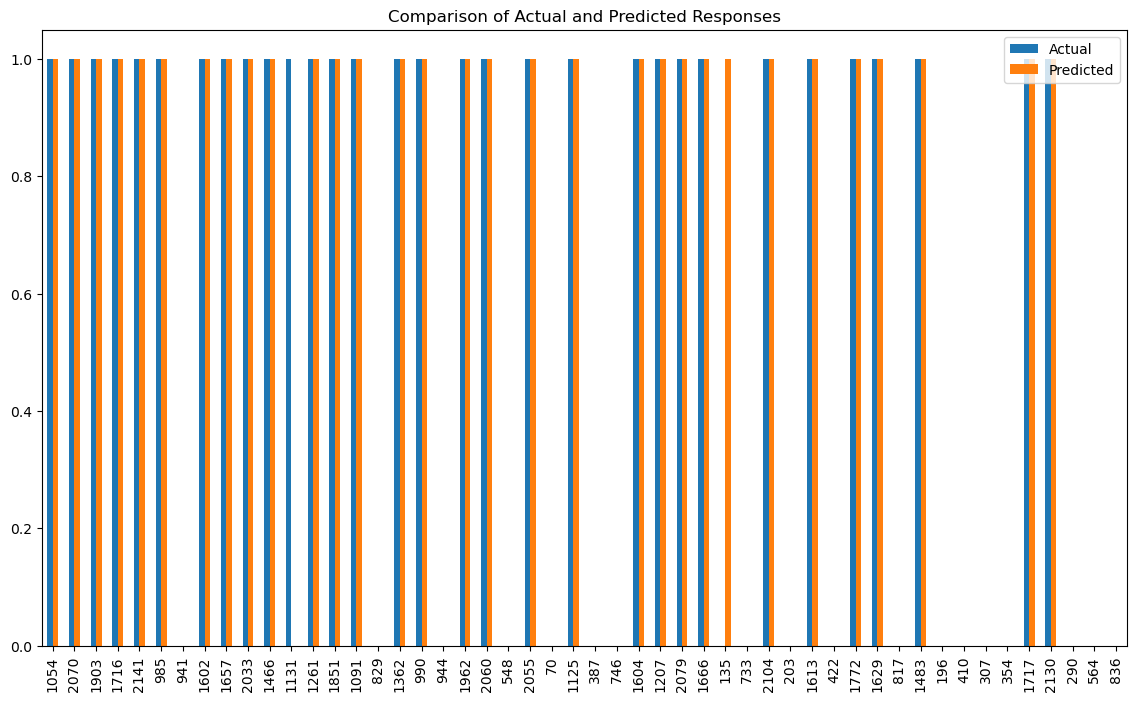

In [111]:
y_test = np.squeeze(y_test)
y_pred = np.squeeze(y_pred)

# Compare actual and predicted responses
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Sample some data to plot
sampled_data = comparison_df.sample(50, random_state=42)
sampled_data.plot(kind='bar', figsize=(14, 8))
plt.title('Comparison of Actual and Predicted Responses')
plt.show()

In [112]:
# Scatter plot for random forest
# 

import matplotlib.pyplot as plt
import numpy as np

features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


NameError: name 'model' is not defined